SciPy version: 1.0.0

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from neural_style_transfer_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [3]:
def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[m,n_H*n_W,n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[m,n_H*n_W,n_C]))
    
    J_content = tf.div(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)), [0, 1]),(4*n_H*n_C*n_W))
    
    return J_content

In [4]:
def gram_matrix(A):
    
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [5]:
def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.div(tf.reduce_sum(tf.square(tf.subtract(GS,GG)), [0, 1]),(4*((n_H*n_W)**2)*n_C**2))
    
    return J_style_layer

In [6]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [7]:
def compute_style_cost(model, STYLE_LAYERS):
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [8]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha*J_content + beta*J_style
    
    return J

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [10]:
content_image = scipy.misc.imread("images/bulldog1.jpg")
content_image = scipy.misc.imresize(content_image, (CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH))
content_image = reshape_and_normalize_image(content_image)

C:\Users\Tony\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\Tony\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [11]:
style_image = scipy.misc.imread("images/aboriginalBody.jpg")
style_image = scipy.misc.imresize(style_image, (CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH))
style_image = reshape_and_normalize_image(style_image)

C:\Users\Tony\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\Tony\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


W0819 17:55:45.851399  5996 image.py:664] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


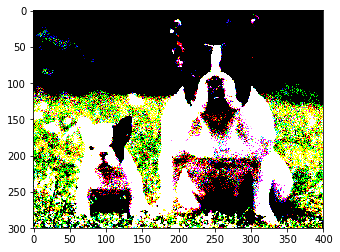

In [12]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [13]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

W0819 17:55:51.347095  5996 deprecation_wrapper.py:119] From C:\Users\Tony\Desktop\TensorProjects\neural_style_transfer_utils.py:124: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [14]:
sess.run(model['input'].assign(content_image))

out = model['conv4_2']

a_C = sess.run(out)

a_G = out

J_content = compute_content_cost(a_C, a_G)

W0819 17:55:53.656153  5996 deprecation.py:323] From <ipython-input-3-6c01a0886cd7>:7: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [15]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [16]:
J = total_cost(J_content, J_style)

In [17]:
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

In [18]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("output/" + str(i) + ".png", generated_image)
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)